# King County Home Sales Analysis and Price Prediction
---
**Scott Aylward  
WGU CS Capstone**  

This interactive notebook explores the King County home sales dataset, applies regression models for price prediction, and provides visualizations and interactive widgets to enable the use of a trained model.

The original dataset can be found [here](https://www.kaggle.com/harlfoxem/housesalesprediction)

# Data Analysis

## Notebook Setup

In [1]:
import warnings
warnings.simplefilter('ignore')

In [2]:
# start by making sure we have the right packages
import sys
!{sys.executable} -m pip install folium branca iPywidgets seaborn jedi==0.17.2

In [3]:
# do some initial imports. We'll definitely want this stuff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Data Import

In [4]:
# import king county house sales dataset
# kcdata = pd.read_csv('kc_house_data.csv')
kcdata = pd.read_csv('https://raw.githubusercontent.com/highgeere/price_prediction/main/kc_house_data.csv')
kcdata.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [5]:
# check out our dtypes and possible nulls
kcdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

## Data Subset Preparation
The dataset contains information across King County, but we're focusing on a few areas of specific interest for new development.

In [6]:
# see how many records we have for each zip
kcdata['zipcode'].value_counts()

98103    602
98038    590
98115    583
98052    574
98117    553
        ... 
98102    105
98010    100
98024     81
98148     57
98039     50
Name: zipcode, Length: 70, dtype: int64

In [7]:
# Split out the three zip codes we're most interested in
# north seattle, maple valley, and redmond
zips = [98103, 98038, 98052]
kc98103 = kcdata[kcdata['zipcode'] == zips[0]].copy()
kc98038 = kcdata[kcdata['zipcode'] == zips[1]].copy()
kc98052 = kcdata[kcdata['zipcode'] == zips[2]].copy()
kczips = [kc98103,kc98038,kc98052]

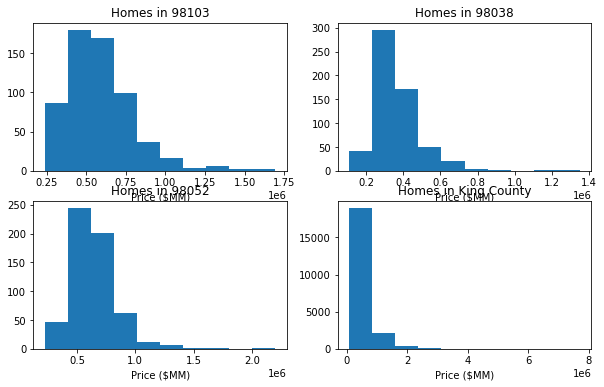

In [8]:
# let's check out the price histogram for the areas of interest along with the whole county
fig, ((ax0,ax1),(ax2,ax3)) = plt.subplots(figsize=(10,6),nrows=2,ncols=2)
ax0.hist(kc98103['price'])
ax0.set(title='Homes in 98103', xlabel='Price ($MM)')
ax1.hist(kc98038['price'])
ax1.set(title='Homes in 98038', xlabel='Price ($MM)')
ax2.hist(kc98052['price'])
ax2.set(title='Homes in 98052', xlabel='Price ($MM)');
ax3.hist(kcdata['price'])
ax3.set(title='Homes in King County', xlabel='Price ($MM)');

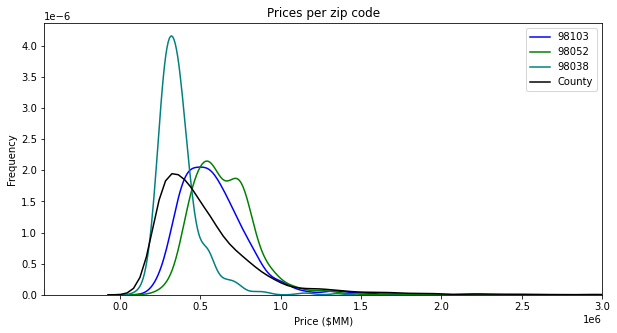

In [9]:
# we'll see it as a density plot as well
f,ax=plt.subplots(figsize=(10, 5))

ax=sns.kdeplot(kc98103['price'],label='98103',color='blue')
sns.kdeplot(kc98052['price'],label='98052',color='g',ax=ax)
sns.kdeplot(kc98038['price'],label='98038',color='teal',ax=ax)
sns.kdeplot(kcdata['price'],label='County',color='black',ax=ax)
ax.set(ylabel='Frequency', xlabel='Price ($MM)')
ax.set_xlim(right=3000000)
ax.legend(['98103','98052','98038','County'])
plt.title("Prices per zip code");

## Feature Evaluation

Let's look at the features of the dataset to determine what to keep.

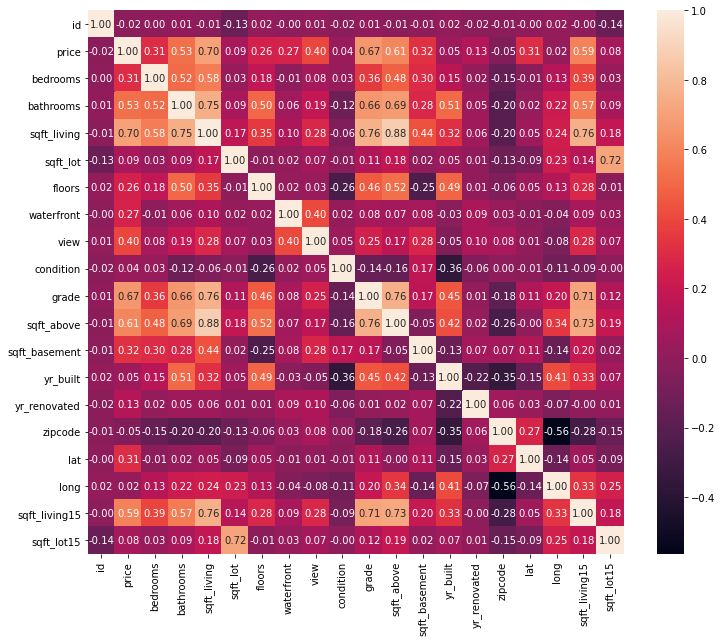

In [10]:
# Correlation matrix heatmap
import seaborn as sns

fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(kcdata.corr(), annot=True, fmt='.2f', ax=ax)
plt.show()

In [11]:
# The id isn't relevant, and we aren't doing time-series, so drop id and date
kcdata.drop(['id','date'], axis=1, inplace=True)

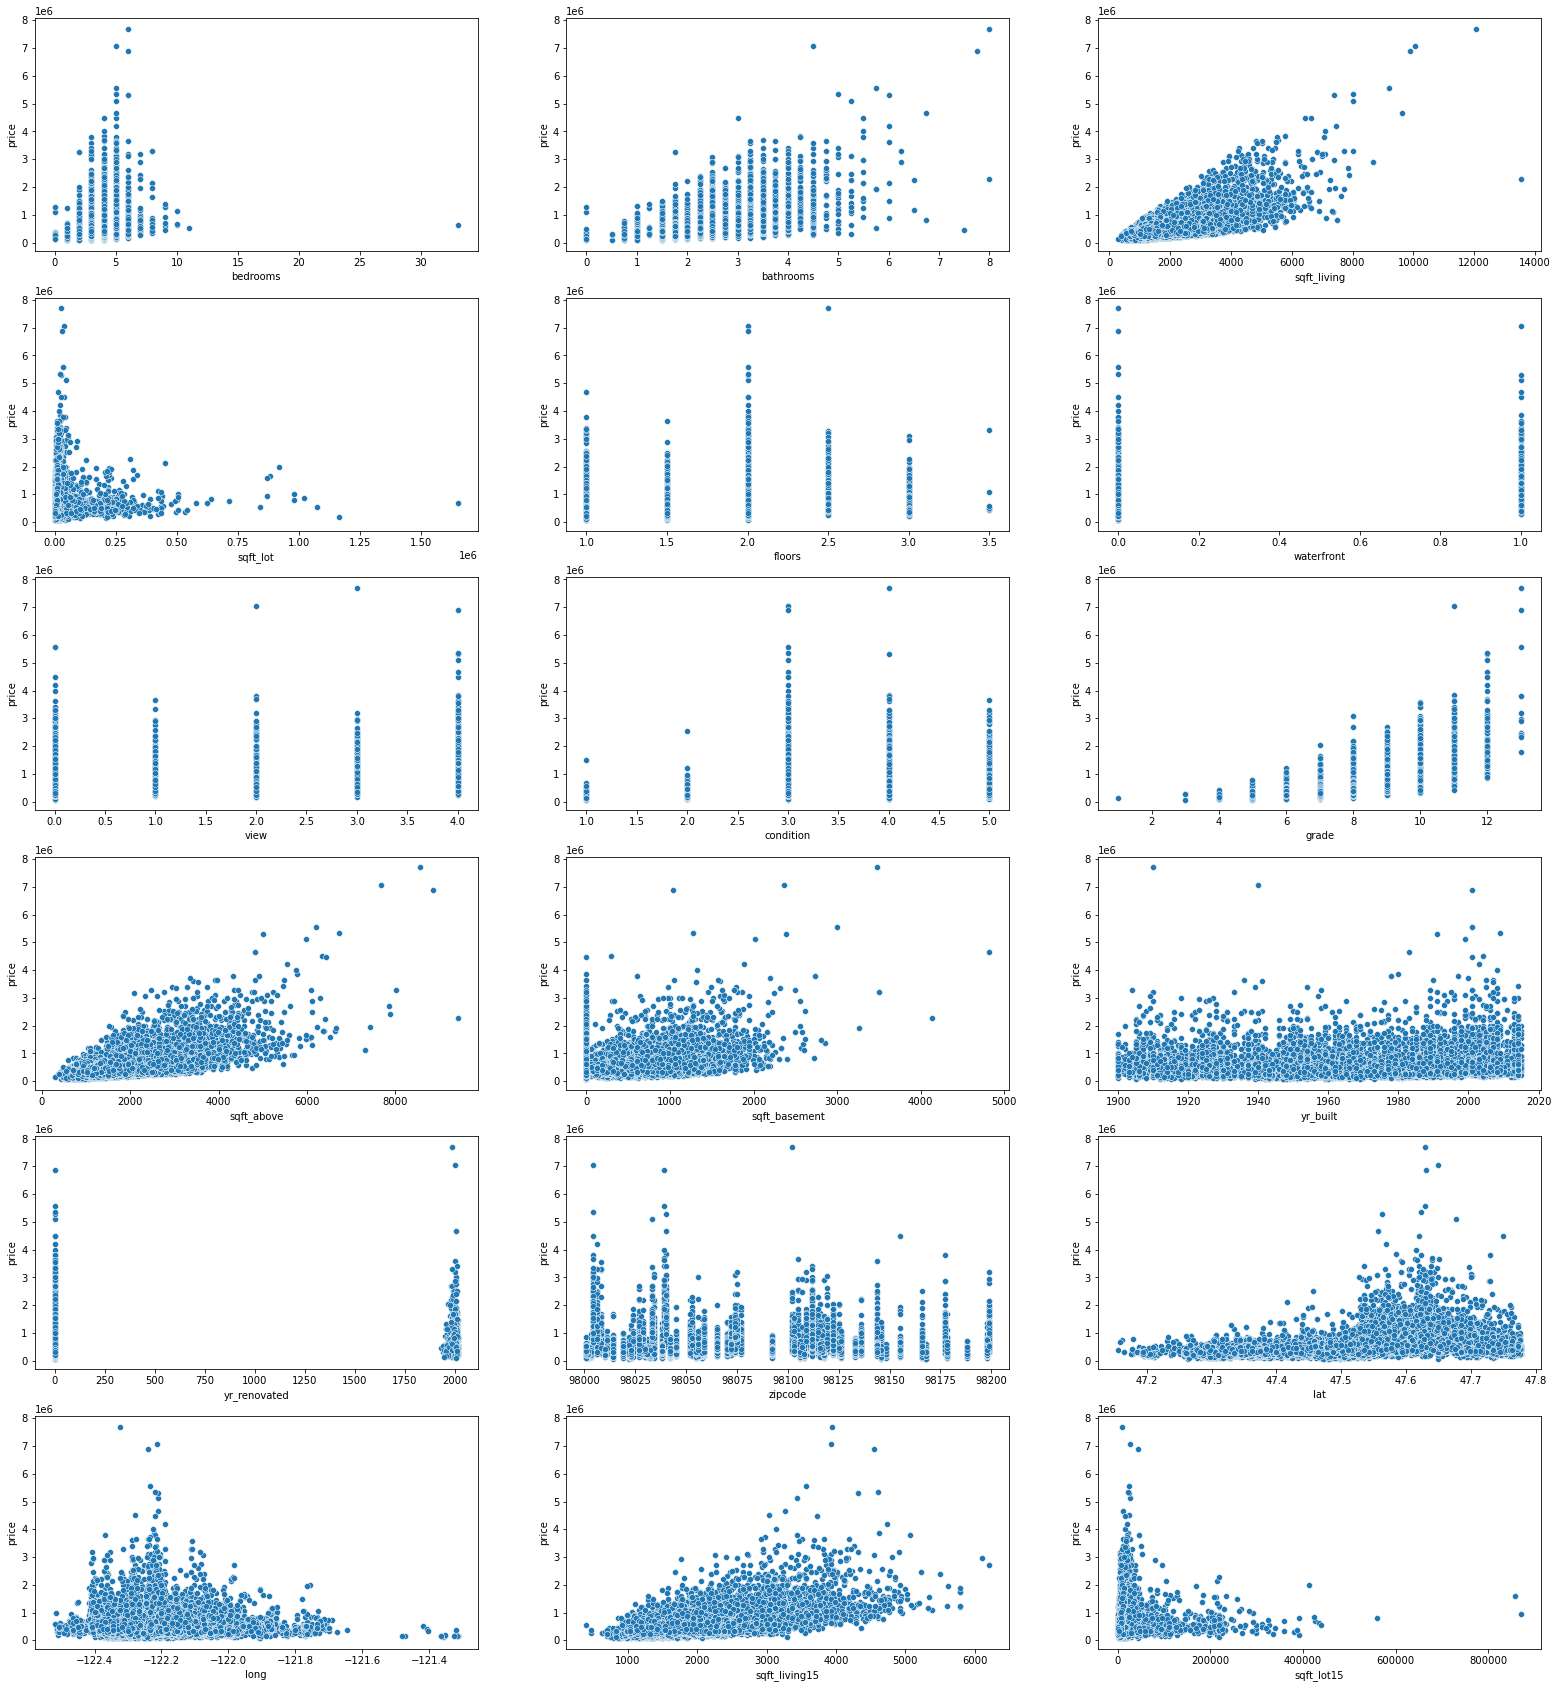

In [12]:
# let's visualize each feature(except id) with a scatter plot with price as y
fig, ax= plt.subplots(figsize=(27,30), ncols=3, nrows=6)
sns.scatterplot(x="bedrooms", y="price",data=kcdata, ax=ax[0][0])
sns.scatterplot(x="bathrooms", y="price",data=kcdata, ax=ax[0][1])
sns.scatterplot(x="sqft_living", y="price",data=kcdata, ax=ax[0][2])
sns.scatterplot(x="sqft_lot", y="price",data=kcdata, ax=ax[1][0])
sns.scatterplot(x="floors", y="price",data=kcdata, ax=ax[1][1])
sns.scatterplot(x="waterfront", y="price",data=kcdata, ax=ax[1][2])
sns.scatterplot(x="view", y="price",data=kcdata, ax=ax[2][0])
sns.scatterplot(x="condition", y="price",data=kcdata, ax=ax[2][1])
sns.scatterplot(x="grade", y="price",data=kcdata, ax=ax[2][2])
sns.scatterplot(x="sqft_above", y="price",data=kcdata, ax=ax[3][0])
sns.scatterplot(x="sqft_basement", y="price",data=kcdata, ax=ax[3][1])
sns.scatterplot(x="yr_built", y="price",data=kcdata, ax=ax[3][2])
sns.scatterplot(x="yr_renovated", y="price",data=kcdata, ax=ax[4][0])
sns.scatterplot(x="zipcode", y="price",data=kcdata, ax=ax[4][1])
sns.scatterplot(x="lat", y="price",data=kcdata, ax=ax[4][2])
sns.scatterplot(x="long", y="price",data=kcdata, ax=ax[5][0])
sns.scatterplot(x="sqft_living15", y="price",data=kcdata, ax=ax[5][1])
sns.scatterplot(x="sqft_lot15", y="price",data=kcdata, ax=ax[5][2])
plt.show();

We should back up the visual observations with numerical data.

In [13]:
kc_corr = {}
for f in kcdata.columns:
    kc_corr[f] = (kcdata[f].corr(kcdata['price']))
    
kc_corr = {k: v for k, v in sorted(kc_corr.items(), key=lambda item: item[1], reverse=True)}

In [14]:
pd.DataFrame(kc_corr.items(), columns=['Feature', 'Correlation w/ price'])

,Feature,Correlation w/ price
0,price,1.000000
1,sqft_living,0.702035
2,grade,0.667434
3,sqft_above,0.605567
4,sqft_living15,0.585379
5,bathrooms,0.525138
6,view,0.397293
7,sqft_basement,0.323816
8,bedrooms,0.308350
9,lat,0.307003


## Data Cleaning
Now we'll prune the features that don't significantly impact the price, and examine the dataset for outliers. As we saw in the original info() output, we have no nulls to address.

In [15]:
# create truncated location dataframe before we strip zipcode and long
kc_locs = kcdata.filter(['zipcode','lat', 'long', 'price'])

# drop the features we aren't interested in
kcdata.drop(['condition', 'long', 'zipcode',
       'sqft_lot15','yr_built', 'sqft_lot',
       'waterfront','yr_renovated', 'sqft_living15'],axis=1,inplace=True)

In [16]:
# Remaining features
kcdata.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
price,21613.0,540088.141767,367127.196483,75000.0000,321950.000,450000.0000,645000.000,7.700000e+06
bedrooms,21613.0,3.370842,0.930062,0.0000,3.000,3.0000,4.000,3.300000e+01
bathrooms,21613.0,2.114757,0.770163,0.0000,1.750,2.2500,2.500,8.000000e+00
sqft_living,21613.0,2079.899736,918.440897,290.0000,1427.000,1910.0000,2550.000,1.354000e+04
floors,21613.0,1.494309,0.539989,1.0000,1.000,1.5000,2.000,3.500000e+00
view,21613.0,0.234303,0.766318,0.0000,0.000,0.0000,0.000,4.000000e+00
grade,21613.0,7.656873,1.175459,1.0000,7.000,7.0000,8.000,1.300000e+01
sqft_above,21613.0,1788.390691,828.090978,290.0000,1190.000,1560.0000,2210.000,9.410000e+03
sqft_basement,21613.0,291.509045,442.575043,0.0000,0.000,0.0000,560.000,4.820000e+03
lat,21613.0,47.560053,0.138564,47.1559,47.471,47.5718,47.678,4.777760e+01


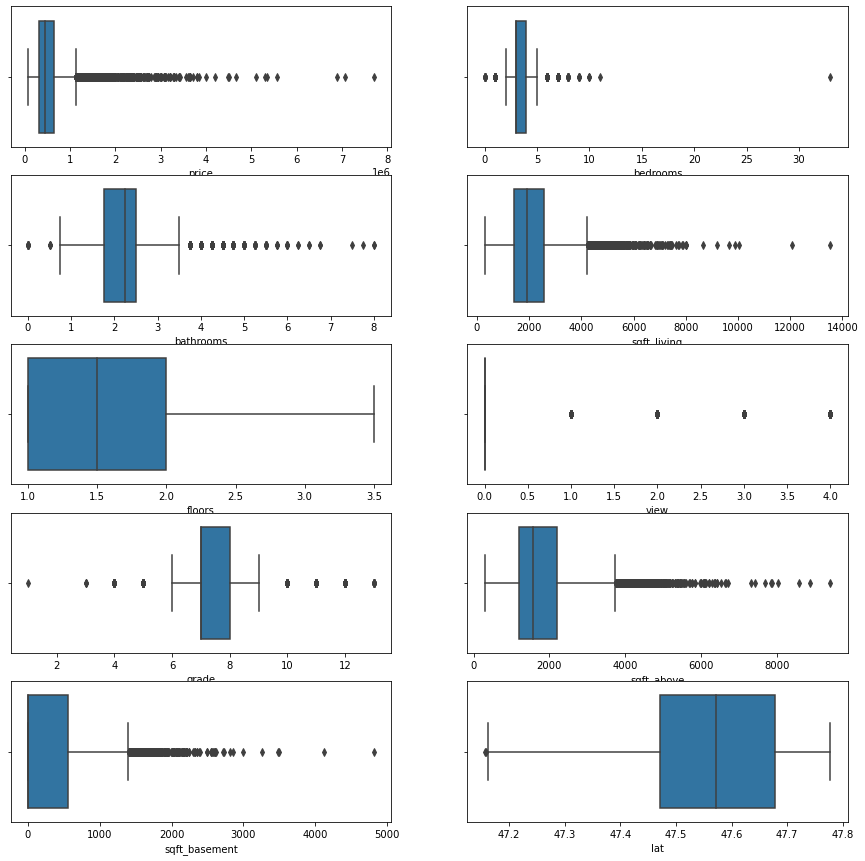

In [17]:
# look at outliers using box plots
fig, ax = plt.subplots(figsize=(15,15), nrows=5, ncols=2)
sns.boxplot(x=kcdata['price'],data=kcdata,ax=ax[0][0])
sns.boxplot(x=kcdata['bedrooms'],data=kcdata,ax=ax[0][1])
sns.boxplot(x=kcdata['bathrooms'],data=kcdata,ax=ax[1][0])
sns.boxplot(x=kcdata['sqft_living'],data=kcdata,ax=ax[1][1])
sns.boxplot(x=kcdata['floors'],data=kcdata,ax=ax[2][0])
sns.boxplot(x=kcdata['view'],data=kcdata,ax=ax[2][1])
sns.boxplot(x=kcdata['grade'],data=kcdata,ax=ax[3][0])
sns.boxplot(x=kcdata['sqft_above'],data=kcdata,ax=ax[3][1])
sns.boxplot(x=kcdata['sqft_basement'],data=kcdata,ax=ax[4][0])
sns.boxplot(x=kcdata['lat'],data=kcdata,ax=ax[4][1]);

### Outliers

In [18]:
# create some functions to handle outliers with IQR
def find_outliers(feat):
    Q1,Q3 = np.percentile(feat, [25,75])
    IQR = Q3 - Q1
    lower = Q1 - (1.5 * IQR)
    upper = Q3 + (1.5 * IQR)
    print(lower, upper)
    return lower, upper

def remove_outliers(df, feat):
    lower, upper = find_outliers(df[feat])
    df[feat] = np.where(df[feat]>upper, upper, df[feat])
    df[feat] = np.where(df[feat]<lower, lower, df[feat])

In [19]:
# We'll remove outliers for only a couple of features
remove_outliers(kcdata, 'bedrooms')
remove_outliers(kcdata, 'price')

for d in kczips:
    remove_outliers(d, 'bedrooms')
    remove_outliers(d, 'price')

1.5 5.5
-162625.0 1129575.0
0.5 4.5
37812.5 1089312.5
1.5 5.5
98125.0 597125.0
1.5 5.5
147093.75 1113343.75


In [20]:
# Look at the feature info again
kcdata.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
price,21613.0,511587.282099,250002.623573,75000.0000,321950.000,450000.0000,645000.000,1.129575e+06
bedrooms,21613.0,3.362791,0.854105,1.5000,3.000,3.0000,4.000,5.500000e+00
bathrooms,21613.0,2.114757,0.770163,0.0000,1.750,2.2500,2.500,8.000000e+00
sqft_living,21613.0,2079.899736,918.440897,290.0000,1427.000,1910.0000,2550.000,1.354000e+04
floors,21613.0,1.494309,0.539989,1.0000,1.000,1.5000,2.000,3.500000e+00
view,21613.0,0.234303,0.766318,0.0000,0.000,0.0000,0.000,4.000000e+00
grade,21613.0,7.656873,1.175459,1.0000,7.000,7.0000,8.000,1.300000e+01
sqft_above,21613.0,1788.390691,828.090978,290.0000,1190.000,1560.0000,2210.000,9.410000e+03
sqft_basement,21613.0,291.509045,442.575043,0.0000,0.000,0.0000,560.000,4.820000e+03
lat,21613.0,47.560053,0.138564,47.1559,47.471,47.5718,47.678,4.777760e+01


## Geo Vizualization
Before we continue to application of regression models, let's visualize the data geographically using the subset of zip codes we're interested in. 

In [21]:
import folium
import branca

In [22]:
from folium.plugins import HeatMap

# function in case I want to use more of these maps
def generateBaseMap(default_location=[47.55, -122.15], default_zoom_start=9.6):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

# setting the color map for the markers and lengend
colormap = branca.colormap.LinearColormap(colors=['purple','blue','teal','cyan','lime'],
                             vmin=kc_locs['price'].min(), vmax=kc_locs['price'].max(),
                             caption='Sale Value ($)')

gradient_dict = {0.2: 'purple', 0.4:'blue', 0.65:'teal', 0.75:'cyan',0.95:'lime'}

heatmap = generateBaseMap()
colormap.add_to(heatmap)
# add heatmaps for each zip
HeatMap(data=kc98103[['lat','long','price']].groupby(['lat','long']).sum().reset_index().values.tolist(),
        radius=8,max_zoom=13,name='98103',gradient=gradient_dict,blur=12).add_to(heatmap)
HeatMap(data=kc98052[['lat','long','price']].groupby(['lat','long']).sum().reset_index().values.tolist(),
        radius=8,max_zoom=13,name='98052',gradient=gradient_dict,blur=12).add_to(heatmap)
HeatMap(data=kc98038[['lat','long','price']].groupby(['lat','long']).sum().reset_index().values.tolist(),
        radius=8,max_zoom=13,name='98038',gradient=gradient_dict,blur=12).add_to(heatmap)
folium.LayerControl(collapsed=False).add_to(heatmap);

In [23]:
# now build a cluster marker map to show density
from folium.plugins import MarkerCluster

clustermap = generateBaseMap()

marker_cluster = MarkerCluster().add_to(clustermap)

for d in kczips:
    for ind, row in d.filter(['lat', 'long', 'price']).iterrows():
        folium.Marker(location=list((row[0],row[1])), popup=str(row[2])).add_to(marker_cluster)


### Interactive Maps
Heatmap - Zoom in to see how prices are distributed in each area
ClusterMap - Zoom in to see where clusters of homes are located. Click each marker to see the price at that location

In [24]:
from IPython.core.display import display, HTML

htmlmap = HTML('<iframe srcdoc="{}" style="float:left; width: {}px; height: {}px; display:inline-block; width: 45%; margin: 0 auto; border: 2px solid black"></iframe>'
           '<iframe srcdoc="{}" style="width: {}px; height: {}px; display:inline-block; width: 45%; margin: 0 auto; border: 2px solid black"></iframe>'
           .format(heatmap.get_root().render().replace('"', '&quot;'),400,500,
                   clustermap.get_root().render().replace('"', '&quot;'),400,500))
display(htmlmap)

# Regression Models

Now we're ready to test some regression models. We'll use data from all ZIP codes for this step, to get the best analysis across the features. More samples will reduce our Mean Squared Error, without necessarily improving the models' scores.

In [25]:
# start modeling the main dataset using a few different regressors

# set up some lists fo use in comparing the models
model = []
score = []
model_pred = []
score_pred = []

X=kcdata.drop(['price'],axis=1)
y=kcdata['price']

# import regression models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# split our test set with predictable random seed
np.random.seed(37)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Training

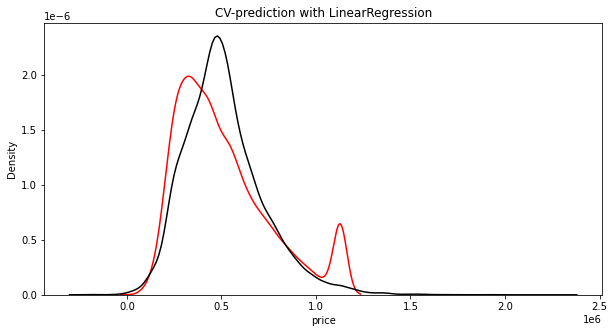

In [26]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# linear regression
LinReg=LinearRegression()
LinReg.fit(X_train,y_train)

# scoring methods
from sklearn.model_selection import  cross_val_score,cross_val_predict
cv_LinReg=cross_val_score(LinReg,X_train,y_train,cv=10)
cv_LinReg_pred=cross_val_predict(LinReg,X_train,y_train,cv=10)

model.append("Linear Regression")
score.append(r2_score(y_train,cv_LinReg_pred))

#Visualisation
fig,ax=plt.subplots(figsize=(10, 5))
ax=sns.kdeplot(y_train,label='Y-Train',color='r', legend=True)
sns.kdeplot(cv_LinReg_pred,label='Pred-CV-Value',color='black',ax=ax, legend=True)
plt.title("CV-prediction with LinearRegression");

Text(0.5, 1.0, 'CV-prediction with DecisionTreeRegressor')

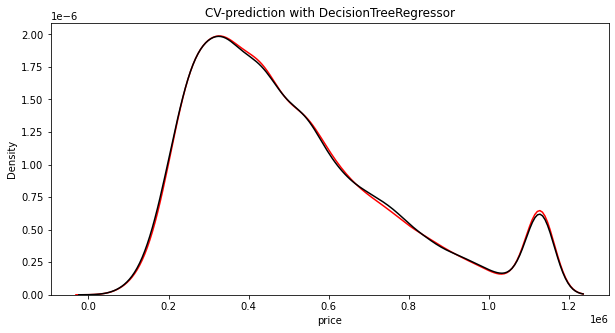

In [27]:
# Decision tree regression
DTR=DecisionTreeRegressor()
DTR.fit(X_train,y_train)

from sklearn.model_selection import  cross_val_score,cross_val_predict
cv_DTR=cross_val_score(DTR,X_train,y_train,cv=10)
cv_DTR_pred=cross_val_predict(DTR,X_train,y_train,cv=10)

model.append("DecisionTreeRegressor")
score.append(r2_score(y_train,cv_DTR_pred)) 

#Visualisation
fig,ax=plt.subplots(figsize=(10, 5))
ax=sns.kdeplot(y_train,label='Y-Train',color='r')
sns.kdeplot(cv_DTR_pred,label='Pred-CV-Value',color='black',ax=ax)
plt.title("CV-prediction with DecisionTreeRegressor");

Text(0.5, 1.0, 'CV-prediction with RandomForestRegressor')

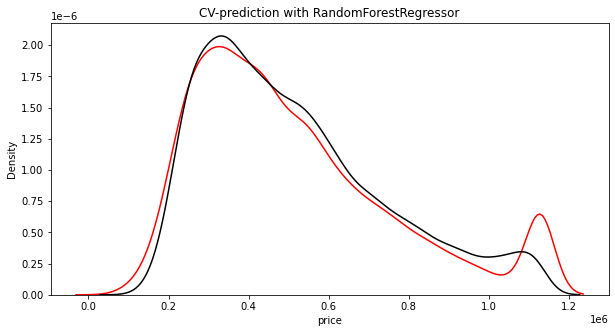

In [28]:
# random forest regression
RFR=RandomForestRegressor(n_estimators=100, random_state = 42)
RFR.fit(X_train,y_train)

from sklearn.model_selection import  cross_val_score,cross_val_predict
cv_RFR=cross_val_score(RFR,X_train,y_train,cv=10)
cv_RFR_pred=cross_val_predict(RFR,X_train,y_train,cv=10)

model.append("RandomForestRegressor")
score.append(r2_score(y_train,cv_RFR_pred)) 

#Visualisation
fig,ax=plt.subplots(figsize=(10, 5))
ax=sns.kdeplot(y_train,label='Y-Train',color='r')
sns.kdeplot(cv_RFR_pred,label='Pred-CV-Value',color='black',ax=ax)
plt.title("CV-prediction with RandomForestRegressor")

### Evaluation

Text(0.5, 1.0, 'Prediction with test features in LinearRegression')

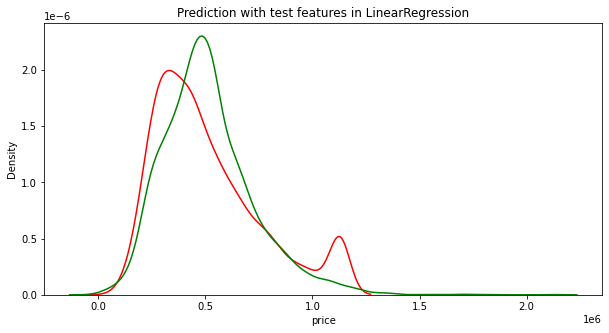

In [29]:
#LinearRegression predictions for test set
LinReg.fit(X_train,y_train)
LinReg_pred=LinReg.predict(X_test)

model_pred.append("Linear Regression")
score_pred.append(r2_score(y_test,LinReg_pred))

#Visualisation
f,ax=plt.subplots(figsize=(10, 5))
ax=sns.kdeplot(y_test,label='Test data',color='r')
sns.kdeplot(LinReg_pred,label='Pred-Value',color='g',ax=ax)
plt.title("Prediction with test features in LinearRegression");

Text(0.5, 1.0, 'Prediction with test features via DecisionTreeRegressor')

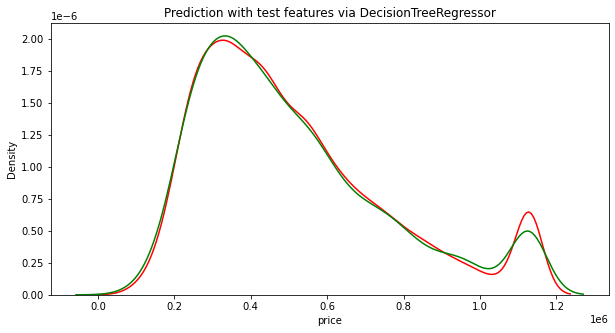

In [30]:
# Decision tree regression predictions for test set
DTR.fit(X_train,y_train)
DTR_pred=DTR.predict(X_test)

model_pred.append("DecisionTreeRegressor")
score_pred.append(r2_score(y_test,DTR_pred))

#Visualisation
f,ax=plt.subplots(figsize=(10, 5))
ax=sns.kdeplot(y_train,label='Test data',color='r')
sns.kdeplot(DTR_pred,label='Predictions',color='g',ax=ax)
plt.title("Prediction with test features via DecisionTreeRegressor");

Text(0.5, 1.0, 'Prediction with test features via RandomForestRegressor')

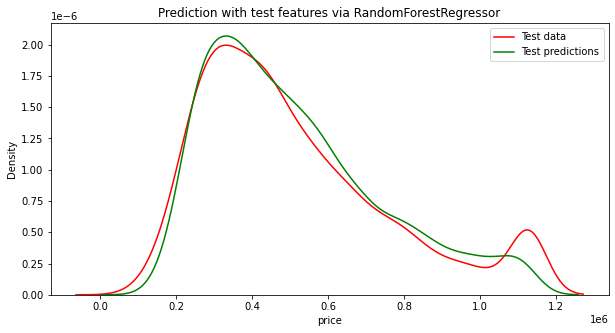

In [31]:
# random forest regression predictions for test set
RFR.fit(X_train,y_train)
RFR_pred=RFR.predict(X_test)

model_pred.append("RandomForestRegressor")
score_pred.append(r2_score(y_test,RFR_pred))

#Visualisation
f,ax=plt.subplots(figsize=(10, 5))
ax=sns.kdeplot(y_test,label='Test data',color='r')
sns.kdeplot(RFR_pred,label='Test predictions',color='g',ax=ax)
#sns.kdeplot(cv_RFR_pred,label='Pred-CV-Value',color='black',ax=ax)
plt.legend()
plt.title("Prediction with test features via RandomForestRegressor");

### Scoring

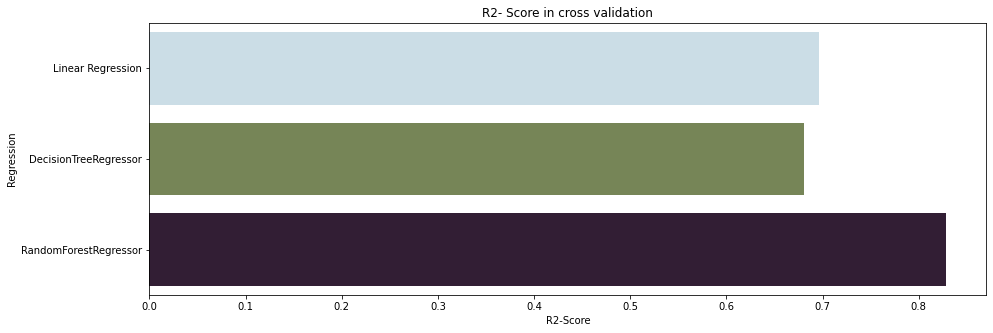

In [32]:
# Cross validation score for our three models
plt.subplots(figsize=(15, 5)) 
sns.barplot(x=score,y=model,palette = sns.cubehelix_palette(len(score),rot=21))
plt.xlabel("R2-Score")
plt.ylabel("Regression")
plt.title('R2- Score in cross validation')
plt.show()

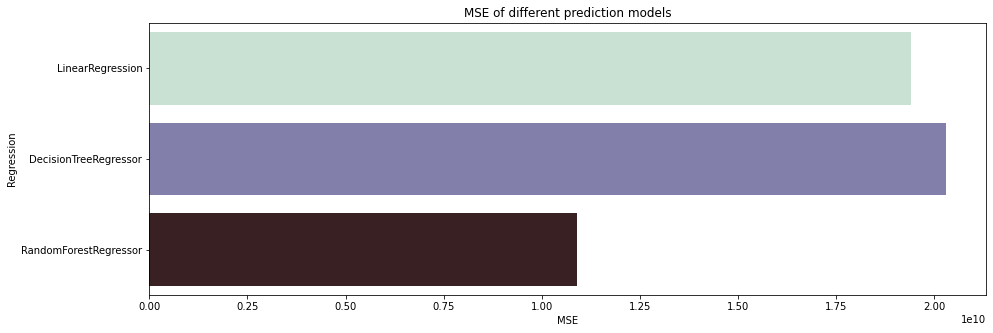

In [33]:
# mean squared error for the three models
MSE=[]
Regressor=[]

MSE.append(mean_squared_error(y_test,LinReg_pred)),Regressor.append('LinearRegression')
MSE.append(mean_squared_error(y_test,DTR_pred)),Regressor.append('DecisionTreeRegressor')
MSE.append(mean_squared_error(y_test,RFR_pred)),Regressor.append('RandomForestRegressor')

plt.subplots(figsize=(15, 5)) 
sns.barplot(x=MSE,y=Regressor,palette = sns.cubehelix_palette(len(MSE),rot=2))
plt.xlabel("MSE")
plt.ylabel("Regression")
plt.title('MSE of different prediction models')
plt.show()

### Evaluation against target subsets
The RandomForestRegressor worked best for our dataset. Now let's see how it does against just the ZIPs we've isolated

In [34]:
# need to clean these up
for d in kczips:
    d.drop(['id','date','condition', 'long', 'zipcode',
        'sqft_lot15','yr_built', 'sqft_lot',
        'waterfront','yr_renovated', 'sqft_living15'],axis=1,inplace=True)

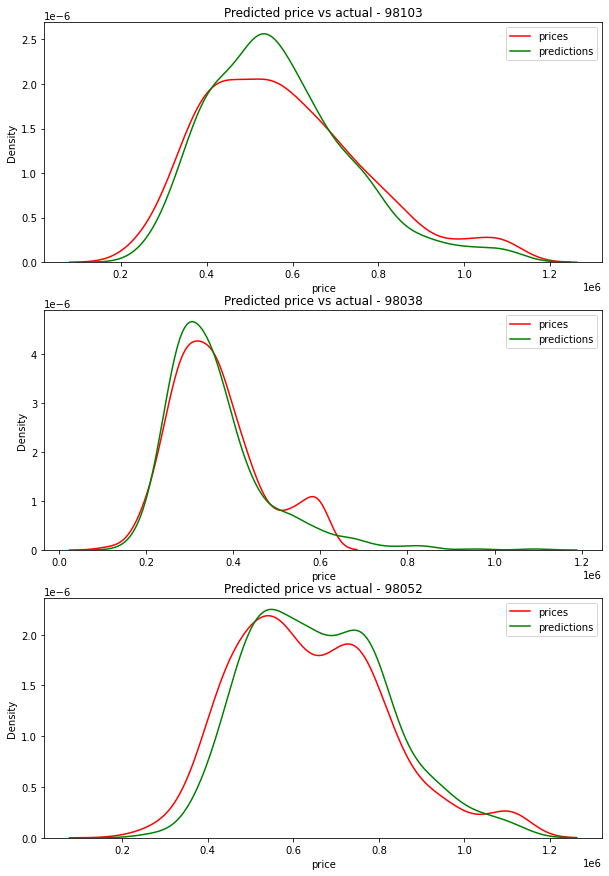

In [35]:
zpreds = {}
zscores = {}

for z, d in zip(zips, kczips):
    X=d.drop(['price'],axis=1)
    y=d['price']
    pred=RFR.predict(X)
    zpreds[z] = [pred, y]
    zscores[str(z)] = r2_score(y,pred)

#Visualization
fig,(ax0,ax1,ax2) = plt.subplots(figsize=(10, 15), nrows=3, ncols=1)
sns.kdeplot(zpreds[98103][1],label='prices',color='r', ax=ax0)
sns.kdeplot(zpreds[98103][0],label='predictions',color='g',ax=ax0)
sns.kdeplot(zpreds[98038][1],label='prices',color='r', ax=ax1)
sns.kdeplot(zpreds[98038][0],label='predictions',color='g',ax=ax1)
sns.kdeplot(zpreds[98052][1],label='prices',color='r', ax=ax2)
sns.kdeplot(zpreds[98052][0],label='predictions',color='g',ax=ax2)
ax0.title.set_text("Predicted price vs actual - 98103")
ax0.legend()
ax1.title.set_text("Predicted price vs actual - 98038")
ax1.legend()
ax2.title.set_text("Predicted price vs actual - 98052")
ax2.legend();

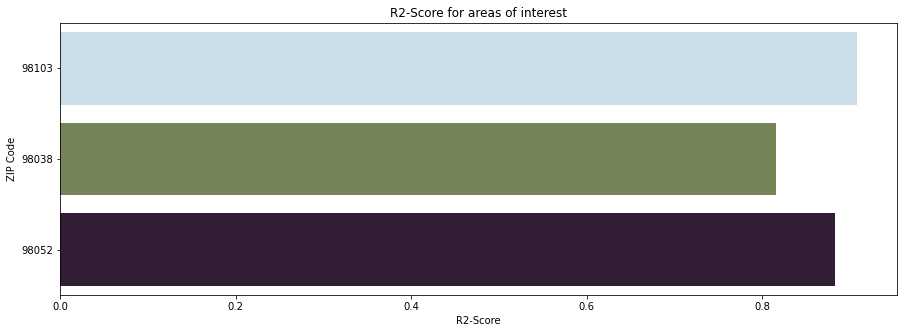

In [36]:
# model scores for each zip code
plt.subplots(figsize=(15, 5)) 
sns.barplot(x=list(zscores.values()),y=list(zscores.keys()),palette = sns.cubehelix_palette(len(zscores),rot=21))
plt.xlabel("R2-Score")
plt.ylabel("ZIP Code")
plt.title('R2-Score for areas of interest')
plt.show()

# Price prediction tool - Application of the trained model
The next cell sets up an inline tool that can be used to estimate a home price based on all considered features. 

In [37]:
# we'll need widgets for the next part
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [38]:
# Widget-related imports
import os
from IPython.display import Image, display, HTML
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [39]:
#Find mean lat values for zipcodes
zip_lat = {}
for zc in zips:
    l = kc_locs[kc_locs['zipcode'] == zc]['lat'].mean()
    zip_lat[str(int(zc))] = l

In [40]:
#@title

def rand_picker(df):
    '''
    Given a dataframe, return a list with a random value selected
    from each column
    '''
    row = []
    for col in df.columns[1:9]:
        row.append(float(np.random.choice(df[col], size=1)))
    row.append(np.random.choice(np.array(list(zip_lat.values()))))
    return row

def test_feats(change):
    '''
    Callback function used by widgets to update predict a price based
    on current inputs. Sets the output field directly.
    '''
    test_row = np.array([beds.value, baths.value, living.value, floors.value, 
                        view.value, grade.value, above.value, basement.value,
                       str(zip_lat[zipcode.value])]).reshape(1, -1)
    guess = RFR.predict(test_row)
    output.value = str("%.2f" % guess[0])
    
def random_feats(change):
    '''
    Updates the selection widgets with values from the 
    rand_picker function.
    '''
    test_row = rand_picker(kcdata)
    beds.value = test_row[0]
    baths.value = test_row[1]
    living.value = test_row[2]
    floors.value = test_row[3]
    view.value = test_row[4]
    grade.value = test_row[5]
    above.value = test_row[6]
    basement.value = test_row[7]
    zipcode.value = next((zc for zc, lat in zip_lat.items() if lat == test_row[8]), None)

# Initialize with random data    
defaults = rand_picker(kcdata)

# Set up slider widgets
beds = widgets.FloatSlider(min=1,max=10,value=defaults[0],step=1, description="Bedrooms",orientation='vertical')
baths = widgets.FloatSlider(min=1,max=10,value=defaults[1],step=0.25, description="Bathrooms",orientation='vertical')
living = widgets.FloatSlider(min=1,max=20000,value=defaults[2],step=50, description="Sqft Living",orientation='vertical')
floors = widgets.FloatSlider(min=1,max=5,value=defaults[3],step=0.5, description="Floors",orientation='vertical')
view = widgets.FloatSlider(min=0,max=4,value=defaults[4],step=1, description="View",orientation='vertical')
grade = widgets.FloatSlider(min=0,max=15,value=defaults[5],step=1, description="Grade",orientation='vertical')
above = widgets.FloatSlider(min=0,max=10000,value=defaults[6],step=50, description="Sqft Above",orientation='vertical')
basement = widgets.FloatSlider(min=0,max=10000,value=defaults[7],step=50, description="Sqft Basement",orientation='vertical')
# set up zip code radio buttons
zipcode = widgets.RadioButtons(
    options=['98103','98038','98052'],
    value='98103',
    description='ZIP Code:',
    disabled=False)
# set up output text box for prediction
output = widgets.Text(
    value=str("%.2f" % RFR.predict(np.array(defaults).reshape(1, -1))[0]),
    description='Estimated Home Price($):',
    disabled=True,
    style={'description_width': 'initial'})

# random values button
rando = widgets.Button(description='Generate Random', disabled=False)
rando.on_click(random_feats)

# widgets observe for changes and run callback function
beds.observe(test_feats)
baths.observe(test_feats)
living.observe(test_feats)
floors.observe(test_feats)
view.observe(test_feats)
grade.observe(test_feats)
above.observe(test_feats)
basement.observe(test_feats)
zipcode.observe(test_feats)

ins = widgets.HBox([beds, baths, living, floors, view, grade, above, basement,zipcode])
out = widgets.HBox([output,rando])



In [41]:
widgets.VBox([ins, out])